In [1]:
import glob as glob
import re
import string
import numpy as np
import pandas as pd
import larch
from larch import io 
from larch import xafs
from larch import Group
from larch import math
from larch import fitting

from larch.math.lincombo_fitting import lincombo_fit
from larch.math.lineshapes import gaussian

from lmfit import Minimizer, Parameters, report_fit
from lmfit.models import LinearModel, LorentzianModel, GaussianModel

import matplotlib
from matplotlib import pyplot as plt

In [2]:
# set matplotlib parameters for generation of pdf figures for publication
matplotlib.rcParams['pdf.fonttype']     = 42
matplotlib.rcParams['xtick.labelsize']  = 6
matplotlib.rcParams['ytick.labelsize']  = 6
matplotlib.rcParams['xtick.major.width'] = 0.25
matplotlib.rcParams['xtick.minor.width'] = 0.25
matplotlib.rcParams['ytick.major.width'] = 0.25
matplotlib.rcParams['ytick.minor.width'] = 0.25
matplotlib.rcParams['xtick.major.size']  = 2.5
matplotlib.rcParams['xtick.minor.size']  = 1.5
matplotlib.rcParams['xtick.major.pad']  = 1.5
matplotlib.rcParams['xtick.minor.pad']  = 1.4
matplotlib.rcParams['ytick.major.size']  = 2.5
matplotlib.rcParams['ytick.minor.size']  = 1.5
matplotlib.rcParams['ytick.major.pad']  = 1.5
matplotlib.rcParams['ytick.minor.pad']  = 1.4
matplotlib.rcParams['axes.labelpad']    = 2


matplotlib.rcParams['lines.linewidth']  = 0.5
matplotlib.rcParams['lines.markersize']  = 2
    
matplotlib.rcParams['font.family']      = 'sans-serif'
matplotlib.rcParams['font.size']        = 10.0
matplotlib.rcParams['font.sans-serif']  = 'Helvetica'

matplotlib.rcParams['axes.linewidth']   = 0.25
matplotlib.rcParams['axes.labelsize']   = 7

matplotlib.rcParams['legend.fontsize']  = 6 
matplotlib.rcParams['legend.handlelength']  = 1 
matplotlib.rcParams['legend.frameon'] = False

In [8]:
# set path (todo: relative path?)
datapath  = '/Users/derkjoester/Documents/Projects/larch/Data/'

# grab all text files in folder
filenames = glob.glob(datapath + '*.txt',recursive = False) 

# read data from files to list and extract experiment names from filename
data = []
expt =[]

for file in filenames:
    # use larch to read data into group
    og = io.read_ascii(file)
    # get filename w/o extension
    m = re.search('/\w*.txt',file)
    expt_ID = m.group(0)[1:-4]
    # generate new group containing only energy and absorption coefficient
    ng = Group(name=expt_ID,energy = og.col1,mu=og.col2)
    ng.name = expt_ID
    # generate list of expt IDs and data
    expt.append(expt_ID)
    data.append(ng)

In [10]:
# re-order list
expt[:] = [expt[i] for i in [3,1,0,2,4]]
data[:] = [data[i] for i in [3,1,0,2,4]]

In [11]:
# determine edge position and fit pre- and post-edge
e_min    = 7050
e_max    = 7300
e_premin = 7105
e_premax = 7120

# define model with 3 gaussians 
def make_model(pars,x,components=False):
    p1 = gaussian(x, pars['amp1'], pars['cen1'], pars['sig1'])
    p2 = gaussian(x, pars['amp2'], pars['cen2'], pars['sig2'])
    p3 = gaussian(x, pars['amp3'], pars['cen3'], pars['sig3'])
    
    model = p1 + p2 + p3
    if components:
        return model, p1, p2, p3
    else:
        return model

# define residual
def resid(pars, x, y, components):
    return make_model(pars, x, components) - y

# create a parameter group for the initial fit:
params = Parameters()
params.add('cen1', value = 7111.0, vary=True, min=7110.5, max=7112)
params.add('cen2', value = 7112.6, vary=True, min=7112.1, max=7113.1)
params.add('cen3', value = 7113.8, vary=True, min=7113.3, max=7114.3)

params.add('amp1', value = 0.25, vary=True, min=0, max=20)
params.add('amp2', value = 0.25, vary=True, min=0, max=20)
params.add('amp3', value = 0.25, vary=True, min=0, max=20)
    
params.add('sig1', value = 1, vary=True, min=0.5, max=20)
params.add('sig2', value = 1, vary=True, min=0.5, max=20)
params.add('sig3', expr = 'sig2')

# create model and parameter group for final fit
#baseline = LinearModel(prefix="base_") + LorentzianModel(prefix="base_")
#peak1 = GaussianModel(prefix="p1_")
#peak2 = GaussianModel(prefix="p2_")
#peak3 = GaussianModel(prefix="p3_")
#final_model = peak1 + peak2 + peak3 + baseline
#final_pars = final_model.make_params()

# initialize dataframe for storage of fit statistics and parameters
pre_edge = pd.DataFrame(index=[
    'baseline_slope',
    'baseline_intercept',
    'baseline_amplitude',
    'baseline_center',
    'baseline_sigma',
    'peak1_amplitude',
    'peak1_center',
    'peak1_sigma',
    'peak1_area_fraction',
    'peak2_amplitude',
    'peak2_center',
    'peak2_sigma',
    'peak2_area_fraction',
    'peak3_amplitude',
    'peak3_center',
    'peak3_sigma',
    'peak3_area_fraction',
    'baseline_model',
    'baseline_chi_sq',
    'baseline_red_chi_sq',
    'baseline_aic',
    'baseline_ndata',
    'baseline_nvarys',
    'peaks_model',
    'peaks_chi_sq',
    'peaks_red_chi_sq',
    'peaks_aic',
    'peaks_ndata',
    'peaks_nvarys'
    ], columns = expt)

constraints = pd.DataFrame(index=[
    'peak1_amplitude',
    'peak1_center',
    'peak1_sigma',
    'peak2_amplitude',
    'peak2_center',
    'peak2_sigma',
    'peak3_amplitude',
    'peak3_center',
    'peak3_sigma',
    ],columns = ['min','max','vary','expr'])

for idx in constraints.index.to_list():
    for col in constraints.columns.to_list():
        m1 = re.search('\d',idx)
        m2 = re.search('_\w*',idx)
        parname = m2.group(0)[1:4]+m1.group(0)
        constraints.loc[idx,col] = getattr(params[parname],col)
    
for ii,d in enumerate(data):  
    # find edge position using larch.xafs.find_e0
    # limit energy because of noise in Core
    xafs.find_e0(d.energy[d.energy<7125],d.mu[d.energy<7125],group=d) 
    
    # set energy limits for fitting
    d.emin   = e_min
    d.emax   = e_max   
    d.premin = e_premin
    d.premax = e_premax
    
    # select window for fitting
    e_win   = (d.emin<=d.energy) & (d.energy<=d.emax)
    d.e = d.energy[e_win]
    d.m = d.mu[e_win]
    
    # fit pre- and post-edge, normalize, and flatten using larch.xafs.pre_edge()
    xafs.pre_edge(
        d.e, d.m, 
        e0 = d.e0,
        group=d,
        nnorm=1, nvict=0
    )
    
    # fit pre-edge features 
    
    # step 1: generate prepeaks group using larch.axafs.prepeaks_setup
    xafs.prepeaks_setup(
        energy = d.e,
        norm   = d.norm,
        group  = d,    
        emin   = 7106,
        elo    = 7108.8,
        ehi    = 7117,
        emax   = 7119, 
        )
    # step 2: fit baseline to prepeaks group
    xafs.pre_edge_baseline(
        energy = d.prepeaks.energy,
        norm   = d.prepeaks.norm,
        emax   = d.prepeaks.emax, 
        emin   = d.prepeaks.emin,
        elo    = d.prepeaks.elo,
        ehi    = d.prepeaks.ehi,
        group  = d,
        form   = 'lorentzian',
        with_line = True
    )
    
    # step 3: fit 3 gaussians + offset to prepeaks.peaks
    minner = Minimizer(resid, params, fcn_args=(d.prepeaks.energy, d.prepeaks.peaks, False))
    d.prepeaks.result = minner.minimize()
    
    # step 4: fit baseline (linear + lorentzian) and peaks (3 gaussians) in one go
    #ipar = d.prepeaks.result.params.valuesdict()
    #final_pars['p1_amplitude'].set(value = ipar['amp1'], vary=True, min=0, max=20)
    #final_pars['p1_center'].set(value = ipar['cen1'], vary=True, min=7110.5, max=7112)
    #final_pars['p1_sigma'].set(value = ipar['sig1'], vary=True, min=0.5, max=20)
    #final_pars['p2_center'].set(value = ipar['cen2'], vary=True, min=7112.1, max=7113.1)
    #final_pars['p2_amplitude'].set(value = ipar['amp2'], vary=True, min=0, max=20)
    #final_pars['p2_sigma'].set(value = ipar['sig2'], vary=True, min=0.5, max=20)
    #final_pars['p3_center'].set(value = ipar['cen3'], vary=True, min=7113.3, max=7114.3)
    #final_pars['p3_amplitude'].set(value = ipar['amp3'], vary=True, min=0, max=20)
    #final_pars['p3_sigma'].set(expr = 'p2_sigma')   

    #ipar = d.prepeaks.fit_details.params.valuesdict()
    #final_pars['base_amplitude'].set(value = ipar['amplitude'], vary=True)
    #final_pars['base_center'].set(value = ipar['center'], vary=True)
    #final_pars['base_sigma'].set(value = ipar['sigma'], vary=True)
    #final_pars['base_slope'].set(value = ipar['slope'], vary=True)
    #final_pars['base_intercept'].set(value = ipar['intercept'], vary=True)

    #d.prepeaks.final_result = final_model.fit(d.prepeaks.norm,final_pars,x=d.prepeaks.energy)
    
    # save fit data to dataframe for export
    basepar = d.prepeaks.fit_details.params.valuesdict()
    peakpar = d.prepeaks.result.params.valuesdict()
    
    pre_edge.loc['baseline_chi_sq',expt[ii]] = d.prepeaks.fit_details.chisqr
    pre_edge.loc['baseline_red_chi_sq',expt[ii]] = d.prepeaks.fit_details.redchi
    pre_edge.loc['baseline_aic',expt[ii]] = d.prepeaks.fit_details.aic
    pre_edge.loc['baseline_ndata',expt[ii]] = d.prepeaks.fit_details.ndata
    pre_edge.loc['baseline_nvarys',expt[ii]] = d.prepeaks.fit_details.nvarys
    
    pre_edge.loc['baseline_model',expt[ii]]='Linear + Lorentzian'
    pre_edge.loc['baseline_intercept',expt[ii]]=basepar['intercept']
    pre_edge.loc['baseline_slope',expt[ii]]=basepar['slope']
    pre_edge.loc['baseline_amplitude',expt[ii]]=basepar['amplitude']
    pre_edge.loc['baseline_center',expt[ii]]=basepar['center']
    pre_edge.loc['baseline_sigma',expt[ii]]=basepar['sigma']
    
    pre_edge.loc['peaks_model',expt[ii]]='3 Gaussians'
    pre_edge.loc['peaks_chi_sq',expt[ii]] = d.prepeaks.result.chisqr
    pre_edge.loc['peaks_red_chi_sq',expt[ii]] = d.prepeaks.result.redchi
    pre_edge.loc['peaks_aic',expt[ii]] = d.prepeaks.result.aic
    pre_edge.loc['peaks_ndata',expt[ii]] = d.prepeaks.result.ndata
    pre_edge.loc['peaks_nvarys',expt[ii]] = d.prepeaks.result.nvarys  
    
    pre_edge.loc['peak1_amplitude',expt[ii]]=peakpar['amp1']
    pre_edge.loc['peak1_center',expt[ii]]=peakpar['cen1']
    pre_edge.loc['peak1_sigma',expt[ii]]=peakpar['sig1']
    pre_edge.loc['peak2_amplitude',expt[ii]]=peakpar['amp2']
    pre_edge.loc['peak2_center',expt[ii]]=peakpar['cen2']
    pre_edge.loc['peak2_sigma',expt[ii]]=peakpar['sig2']
    pre_edge.loc['peak3_amplitude',expt[ii]]=peakpar['amp3']
    pre_edge.loc['peak3_center',expt[ii]]=peakpar['cen3']
    pre_edge.loc['peak3_sigma',expt[ii]]=peakpar['sig3']
    
    area_total = peakpar['amp1'] + peakpar['amp2'] + peakpar['amp3']
    pre_edge.loc['peak1_area_fraction',expt[ii]]= peakpar['amp1']/area_total
    pre_edge.loc['peak2_area_fraction',expt[ii]]= peakpar['amp2']/area_total
    pre_edge.loc['peak3_area_fraction',expt[ii]]= peakpar['amp3']/area_total

In [12]:
# output edge positions:
E0 = pd.DataFrame(index=expt,columns=['E0'])
for ii,ex in enumerate(expt):
    E0['E0'].iloc[ii] = data[ii].e0
    print(f'{ex}: E_0 = {data[ii].e0} eV')
    
# save constraints and fit parameters
E0.to_csv(datapath+'Fe_K_XANES_Linus_E0.csv')
pre_edge.to_csv(datapath+'Fe_K_XANES_Linus_FitPar.csv')
constraints.to_csv(datapath+'Fe_K_XANES_Linus_Constraints.csv')

Core: E_0 = 7123.0938 eV
AFP: E_0 = 7123.0953 eV
composite75: E_0 = 7122.3982 eV
Stylus: E_0 = 7122.8952 eV
SBB: E_0 = 7122.2157 eV


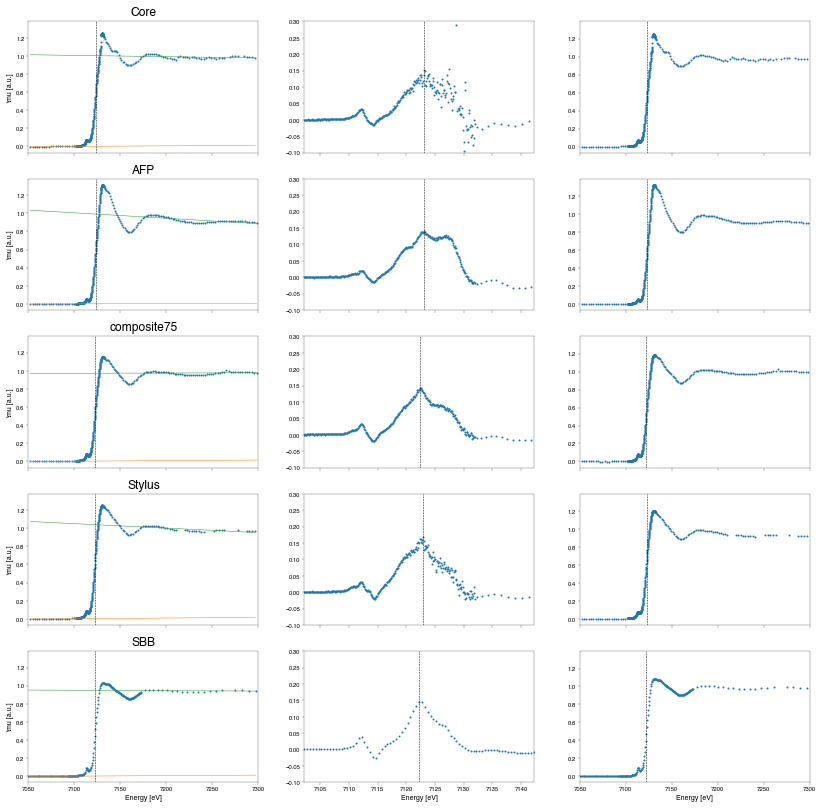

In [13]:
Alphabet = list(string.ascii_uppercase)
# plot pre- and post-edge fits and first derivative
fig,axes = plt.subplots(5,3,figsize=(14,14),sharex='col',sharey='col')
for ii,d in enumerate(data):
    # plot raw data
    axes[ii,0].plot(d.e,d.m,'.')
    # show fit to pre and post edge
    axes[ii,0].plot(d.e,d.pre_edge)
    axes[ii,0].plot(d.e,d.post_edge)
    # indicate E_0
    axes[ii,0].axvline(x=d.e0,color = "black",linestyle = "--")
    # format
    axes[ii,0].set_xlim(d.emin,d.emax)
    axes[ii,0].set_ylabel('\mu [a.u.]')
    axes[ii,0].set_title(d.name)
    
    # plot first derivative of raw data
    axes[ii,1].plot(d.e,d.dmude,'.')
    # indicate E_0
    axes[ii,1].axvline(x=d.e0,color = "black",linestyle = "--")
    axes[ii,1].set_ylim(-0.1,0.3)
    axes[ii,1].set_xlim(d.e0-20,d.e0+20)
    
    # plot normalized data
    axes[ii,2].plot(d.e,d.norm,'.')
    axes[ii,2].set_xlim(d.emin,d.emax)
    # indicate E_0
    axes[ii,2].axvline(x=d.e0,color = "black",linestyle = "--")

axes[-1,0].set_xlabel('Energy [eV]')
axes[-1,1].set_xlabel('Energy [eV]')
axes[-1,2].set_xlabel('Energy [eV]')
plt.savefig('../Fig1_v2.pdf',dpi=600,bbox_inches='tight',pad_inches=0)

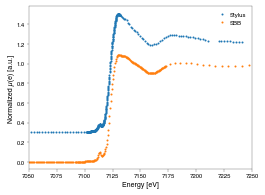

In [24]:
plt.figure(figsize=(4,3))
d1 = data[3]
d2 = data[4]

plt.plot(d1.e,d1.norm+0.3,'.',label=d1.name)
plt.plot(d2.e,d2.norm,'.',label=d2.name)
plt.xlim(d.emin,7250)
plt.xlabel('Energy [eV]')
plt.ylabel('Normalized µ(e) [a.u.]')
plt.legend()
plt.savefig('../FigS15.pdf',dpi=600,bbox_inches='tight',pad_inches=0)

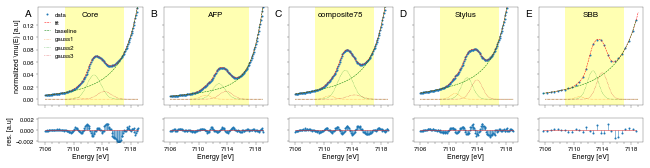

In [14]:
widths = [1, 1, 1, 1, 1]
heights = [1, 0.25]
gs_kw = dict(width_ratios=widths, height_ratios=heights, hspace = 0.2)

figS14, axes = plt.subplots(ncols=5, nrows=2, constrained_layout=False,
        gridspec_kw=gs_kw, sharex=True,sharey='row',figsize = (6.5*5/3,2.5))
        
for ii,d in enumerate(data):
    
    # create fine energy axis for plotting of prepeaks model
    d.prepeaks.efit = np.linspace(d.prepeaks.emin,d.prepeaks.emax,100)
    model,c1,c2,c3  = make_model(d.prepeaks.result.params,d.prepeaks.efit,True)
    baseline        = d.prepeaks.fit_details.eval(x=d.prepeaks.efit)
    
    axes[0,ii].plot(d.prepeaks.energy,d.prepeaks.norm,'.',label='data')
    axes[0,ii].plot(d.prepeaks.efit,model+baseline,'r--',label='fit')
    axes[0,ii].plot(d.prepeaks.energy,d.prepeaks.baseline,'g--',label='baseline') 
    axes[0,ii].plot(d.prepeaks.efit,c1,':',label='gauss1')
    axes[0,ii].plot(d.prepeaks.efit,c2,':',label='gauss2')
    axes[0,ii].plot(d.prepeaks.efit,c3,':',label='gauss3')
    axes[0,ii].fill_betweenx(
        [-0.01,0.15],
        d.prepeaks.elo,
        d.prepeaks.ehi,
        where = d.prepeaks.ehi>d.prepeaks.elo, 
        facecolor = "yellow", alpha = 0.3)
    axes[0,ii].set_ylim(-0.01,0.15)
    axes[0,ii].annotate(expt[ii],(0.5,0.9),xycoords='axes fraction',fontsize=8,horizontalalignment='center')
    axes[0,ii].annotate(Alphabet[ii],(-0.1,0.90),xycoords='axes fraction',fontsize=10,horizontalalignment='center')
    
    # plot residuals
    mline,sline,bline = axes[1,ii].stem(d.prepeaks.energy,d.prepeaks.result.residual)
    mline._markersize = 1
    bline._linewidth  = 0.5
    axes[1,ii].set_ylim(-0.0022,0.0022)
    axes[1,ii].set_xlabel('Energy [eV]')
    axes[1,ii].set_xticks(range(7106,7120,4))
    axes[1,ii].set_xticks(range(7106,7120,1),minor=True)
    
axes[0,0].set_yticks(np.arange(0,0.13,0.02))
axes[0,0].legend()
axes[0,0].set_ylabel('normalized \mu(E) [a.u]')
axes[1,0].set_ylabel('res. [a.u]')
plt.savefig('../FigS14_v2.pdf',dpi=600,bbox_inches='tight',pad_inches=0)

In [ ]:
# linear combination fit: Core = c0 * AFP + c1 * SBB
e_min = 7050
e_max = 7300

# select group from which we'll take the energy axis for interpolation
idx_ip     = expt.index("SBB")
idx_sample = expt.index("Core")
idx_ref1   = expt.index("AFP")
idx_ref2   = expt.index("SBB")

# slice energy window 
e_win    = (e_min<=data[idx_ip].e) & (data[idx_ip].e<=e_max)
e_interp = data[idx_ip].e[e_win]

# interpolate normalized spectra
sample = Group(name = expt[idx_sample],energy = e_interp, norm=np.interp(e_interp,data[idx_sample].e,data[idx_sample].norm))
ref1   = Group(name = expt[idx_ref1],energy = e_interp, norm=np.interp(e_interp,data[idx_ref1].e,data[idx_ref1].norm))
ref2   = Group(name = expt[idx_ref2],energy = e_interp, norm=np.interp(e_interp,data[idx_ref2].e,data[idx_ref2].norm))

# fit using larch.math.lincombo_fitting.lincombo_fit()
lcfit = lincombo_fit(sample,[ref1,ref2])
# plot
fig,axes = plt.subplots(2,1,sharex=True)
axes[0].plot(lcfit.xdata,lcfit.ydata,'--')
axes[0].plot(lcfit.xdata,lcfit.yfit,'r:')
axes[0].set_title('Linear Combination Fit of ' + expt[idx_sample])
mline,stemline,baseline = axes[1].stem(lcfit.xdata,lcfit.ydata-lcfit.yfit)
mline._markersize = 2
axes[1].set_title('Residual')

In [ ]:
print(
    f'{expt[idx_sample]} composed of {lcfit.params[expt[idx_ref1]].value*100:.1f}% {expt[idx_ref1]} and {lcfit.params[expt[idx_ref2]].value*100:.1f}% {expt[idx_ref2]}.'
     )

In [ ]:
# linear combination fit: Core = c0 * AFP + c1 * SBB
e_min = 7050
e_max = 7300

# select group from which we'll take the energy axis for interpolation
idx_ip     = expt.index("SBB")
idx_sample = expt.index("Stylus")
idx_ref1   = expt.index("AFP")
idx_ref2   = expt.index("SBB")

# slice energy window 
e_win    = (e_min<=data[idx_ip].e) & (data[idx_ip].e<=e_max)
e_interp = data[idx_ip].e[e_win]

# interpolate normalized spectra
sample = Group(name = expt[idx_sample],energy = e_interp, norm=np.interp(e_interp,data[idx_sample].e,data[idx_sample].norm))
ref1   = Group(name = expt[idx_ref1],energy = e_interp, norm=np.interp(e_interp,data[idx_ref1].e,data[idx_ref1].norm))
ref2   = Group(name = expt[idx_ref2],energy = e_interp, norm=np.interp(e_interp,data[idx_ref2].e,data[idx_ref2].norm))

# fit using larch.math.lincombo_fitting.lincombo_fit()
lcfit = lincombo_fit(sample,[ref1,ref2])
# plot
fig,axes = plt.subplots(2,1,sharex=True)
axes[0].plot(lcfit.xdata,lcfit.ydata,'.')
axes[0].plot(lcfit.xdata,lcfit.yfit,'r--')
axes[0].set_title('Linear Combination Fit of ' + expt[idx_sample])
mline,stemline,baseline = axes[1].stem(lcfit.xdata,lcfit.ydata-lcfit.yfit)
mline._markersize = 2
axes[1].set_title('Residual')

In [ ]:
print(
    f'Stylus composed of {lcfit.params[expt[idx_ref1]].value*100:.1f}% {expt[idx_ref1]} and {lcfit.params[expt[idx_ref2]].value*100:.1f}% {expt[idx_ref2]}.'
     )